# 1. 라이브러리 불러오기

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 2. 데이터 불러오기

In [3]:
df_summer = pd.read_csv('../data/reefer_data_08_celsius.csv')

In [4]:
df_summer.head()

,alarm_codes,ambient_temperature,made_cd,operating_mode,operating_mode_str,reefer_id,return_air_temperature,supply_air_temperature,temperature_setpoint,when_created
0,NaN,23.81,DAIKIN,0.0,DEFROST,CTEU7543690,-18.31,-21.18,-21.12,2022-08-01 00:00:01
1,NaN,24.81,DAIKIN,3.0,THERMO OFF,BMOU8702005,-18.00,-19.31,-18.00,2022-08-01 00:00:17
2,NaN,28.27,CARRIER,3.0,COOL,ARAU2100036,15.93,15.38,9.50,2022-08-01 00:00:24
3,NaN,25.71,CARRIER,3.0,COOL,CRXU5259163,-19.57,-19.42,-20.00,2022-08-01 00:00:28
4,NaN,27.18,DAIKIN,0.0,DEFROST,BMOU8702941,8.50,2.68,2.00,2022-08-01 00:00:37


## 2-1. CARRIER 데이터만 분리

In [5]:
df_carrier = df_summer.loc[df_summer['made_cd'] == 'CARRIER'].reset_index(drop=True)

In [6]:
df_carrier.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 152726 entries, 0 to 152725
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   alarm_codes             25692 non-null   object 
 1   ambient_temperature     152670 non-null  float64
 2   made_cd                 152726 non-null  object 
 3   operating_mode          149552 non-null  float64
 4   operating_mode_str      149552 non-null  object 
 5   reefer_id               152726 non-null  object 
 6   return_air_temperature  152726 non-null  float64
 7   supply_air_temperature  152671 non-null  float64
 8   temperature_setpoint    152726 non-null  float64
 9   when_created            152726 non-null  object 
dtypes: float64(5), object(5)
memory usage: 11.7+ MB


In [7]:
# 문자열을 datetime으로 변경
import datetime

df_carrier['when_created'] = df_carrier['when_created'].apply(lambda x: datetime.datetime.strptime(x, "%Y-%m-%d %H:%M:%S"))

>Column 설명
- alarm_codes: 발생한 알람코드
- ambient_temperature: 컨테이너 실외기 팬 근처 온도
- made_cd: 컨테이너 브랜드
- operating_mode: 동작 모드 (0~12의 정수)
- operating_mode_str: 동작 모드 이름
- reefer_id: 컨테이너 ID
- return_air_temperature: 순환 온도(=냉기가 한 번 돌고 나서의 내부 온도)
- supply_air_temperature: 공급 온도
- temperature_setpoint: 설정 온도
- when_created: 데이터 수집 일시

In [8]:
df_carrier.groupby(['reefer_id']).size().describe()

count      64.00000
mean     2386.34375
std      1383.07851
min         1.00000
25%      1174.75000
50%      3066.50000
75%      3654.25000
max      4213.00000
dtype: float64

컨테이너 마다 평균 2386개의 데이터를 가지고 있다.

In [9]:
df_carrier.groupby(['operating_mode_str']).size()

operating_mode_str
CONFIG           101
COOL           93983
DEFROST         7442
HEAT             628
IDLE           47187
PROBE CHECK      130
SHUTDOWN          44
START UP          37
dtype: int64

### 2-1-1. DEFROST가 발생한 컨테이너와 발생하지 않은 컨테이너 분리

In [10]:
# DEFROST가 발생한 컨테이너와 발생하지 않은 컨테이너의 데이터프레임을 각각 list에 담기
df_defrost = []
df_non_defrost = []

for col in df_carrier['reefer_id'].unique():
    if "DEFROST" in df_carrier.loc[df_carrier['reefer_id'] == col, 'operating_mode_str'].unique():
        df_defrost.append(df_carrier.loc[df_carrier['reefer_id'] == col].reset_index(drop=True))
    else:
        df_non_defrost.append(df_carrier.loc[df_carrier['reefer_id'] == col].reset_index(drop=True))

In [11]:
# DEFROST가 발생한 컨테이너와 발생하지 않은 컨테이너의 SHUTDOWN 발생 횟수 구하기
count_defrost_and_shutdown = 0
count_non_defrost_and_shutdown = 0

for df in df_defrost:
    if "SHUTDOWN" in df['operating_mode_str'].unique():
        count_defrost_and_shutdown += 1

for df in df_non_defrost:
    if "SHUTDOWN" in df['operating_mode_str'].unique():
        count_non_defrost_and_shutdown += 1

In [12]:
print(f"DEFROST가 발생한 컨테이너의 개수는 {df_carrier['reefer_id'].nunique()}개 중에 {len(df_defrost)}개 입니다.")
print(f"SHUTDOWN이 발생한 컨테이너의 개수는 {df_carrier['reefer_id'].nunique()}개 중에 {count_defrost_and_shutdown+count_non_defrost_and_shutdown}개 입니다.")
print(f"DEFROST가 발생한 컨테이너 중 SHUTDOWN이 발생한 컨테이너는 {len(df_defrost)}개 중에 {count_defrost_and_shutdown}개 입니다.")
print(f"DEFROST가 발생하지 않은 컨테이너 {len(df_non_defrost)}개 중에 SHUTDOWN이 발생한 것은 {count_non_defrost_and_shutdown}개 입니다.")

DEFROST가 발생한 컨테이너의 개수는 64개 중에 42개 입니다.
SHUTDOWN이 발생한 컨테이너의 개수는 64개 중에 7개 입니다.
DEFROST가 발생한 컨테이너 중 SHUTDOWN이 발생한 컨테이너는 42개 중에 1개 입니다.
DEFROST가 발생하지 않은 컨테이너 22개 중에 SHUTDOWN이 발생한 것은 6개 입니다.


### 2-1-2. DEFROST와 SHUTDOWN의 연관성 분석

In [13]:
def pop_sequence_number(num_list):
    """
    DEFROST가 발생한 인덱스를 뽑아내는 함수입니다.

    Inputs
    ----------
    num_list: DEFROST가 발생한 인덱스 번호(1차원 리스트)

    Return
    ------
    packet: DEFROST가 발생한 인덱스 번호 묶음(2차원 리스트)
    """
    packet = []
    tmp = []

    v = num_list.pop(0)
    tmp.append(v)

    while (len(num_list) > 0):
        vv = num_list.pop(0)
        if v+1 == vv:
            tmp.append(vv)
            v = vv
        else:
            packet.append(tmp)
            tmp = []
            tmp.append(vv)
            v = vv
    
    packet.append(tmp)
    return packet

In [14]:
def calculate_after_defrost(df):
    """
    DEFROST가 끝나고 다시 설정 온도로 돌아가기까지 소요되는 시간을 계산하여 초(seconds)로 반환하는 함수입니다.

    Inputs
    ------
    df: DEFROST가 발생한 데이터 프레임(DEFROST가 발생한 이력의 마지막부터 맨 끝까지의 데이터프레임)

    Returns
    -------
    total_seconds: DEFROST 후 설정 온도로 돌아가기까지 소요되는 시간(second)
    """
    df_new = df.reset_index(drop=True)
    DEFROST_TIME = df_new.iloc[0]['when_created']
    df_new = df_new.iloc[1:, :]
    if df_new['temperature_setpoint'].unique()[0] < 0:
        standard_value = df_new['temperature_setpoint'].unique()[0] - df_new['temperature_setpoint'].unique()[0]*0.1 # 온도가 정상으로 돌아갔다는 기준을 다시 설정해야함, 잠깐 정상으로 돌아갔다가 다시 올라가는 경우도 있음..
        idx = df_new.loc[df_new['return_air_temperature'] <= standard_value].index[0] # DEFROST 후 설정 온도로 돌아간 인덱스
    time = df_new.iloc[idx-1]['when_created'] - DEFROST_TIME
    total_seconds = time.total_seconds()

    return total_seconds

In [15]:
def find_timestamp_at_defrost(df):
    """
    DEFROST가 발생한 데이터의 timestamp를 년, 월, 일로 나누고 리스트에 담아 반환하는 함수입니다.

    Inputs
    ------
    df: DEFROST가 발생한 데이터 프레임, datetime64[ns]가 포함되어 있어야 합니다.

    Returns
    -------
    yyyymmdd: 년, 월, 일이 담긴 리스트
    """
    for idx, i in enumerate(df.dtypes):
        if i == 'datetime64[ns]':
            col = df.dtypes.index[idx]
            timestamp = df.iloc[0]
            yyyymmdd = [timestamp[col].year, timestamp[col].month, timestamp[col].day]
            return yyyymmdd

    return print("잘못된 접근입니다. 데이터프레임을 확인 후 다시 시도해주세요.")

In [16]:
def find_timestamp_dataframe(year, month, day, df):
    """
    일 단위로 데이터를 추출하는 함수입니다.

    Inputs
    -------
    year: 년
    month: 월
    day: 일
    df: datetime64[ns]가 포함되어 있는 데이터프레임

    Returns
    -------
    df_timestamp: 특정 날짜의 데이터프레임
    """
    for idx, i in enumerate(df.dtypes):
        if i == 'datetime64[ns]':
            col = df.dtypes.index[idx]
            df_timestamp = df.loc[(df[col].dt.year == int(year)) & (df[col].dt.month == int(month)) & (df[col].dt.day == int(day))].reset_index(drop=True)
            return df_timestamp

    return print("잘못된 접근입니다. 데이터프레임을 확인 후 다시 시도해주세요.")

In [17]:
# DEFROST도 발생하고 SHUTDOWN도 발생한 컨테이너
for i, df in enumerate(df_defrost):
    if "SHUTDOWN" in df['operating_mode_str'].unique():
        shutdown_index = i

In [18]:
# DEFROST도 발생하고 SHUTDOWN도 발생한 컨테이너의 DEFROST 후 상태 확인
total_time = 0
time_dict = {}
timestamp_dict = {}

num_list = df_defrost[shutdown_index].loc[df_defrost[shutdown_index]["operating_mode_str"] == "DEFROST"].index.tolist()
defrost_idx_list = pop_sequence_number(num_list)

for i, idx in enumerate(defrost_idx_list):
    return_time = calculate_after_defrost(df_defrost[shutdown_index].iloc[idx[-1]:, :])
    yyyymmdd = find_timestamp_at_defrost(df_defrost[shutdown_index].iloc[idx[-1]:, :])
    time_dict[i] = return_time
    timestamp_dict[i] = yyyymmdd
    total_time += return_time

print(f"{df_defrost[shutdown_index]['reefer_id'].unique()[0]} 컨테이너는 DEFROST 후 설정 온도로 돌아가는데 소요되는 평균 시간이 {datetime.timedelta(seconds=(total_time // len(defrost_idx_list)))} 입니다.")
print("또한, SHUTDOWN이 발생한 이력이 있습니다.")

IKRU2200681 컨테이너는 DEFROST 후 설정 온도로 돌아가는데 소요되는 평균 시간이 0:39:31 입니다.
또한, SHUTDOWN이 발생한 이력이 있습니다.


In [19]:
for key, value in time_dict.items():
    print(f"{defrost_idx_list[key]} 구간의 소요 시간 > {datetime.timedelta(seconds=(value))}, 발생일자: {timestamp_dict[key][0]}년 {timestamp_dict[key][1]}월 {timestamp_dict[key][2]}일")

[243, 244, 245] 구간의 소요 시간 > 0:30:37, 발생일자: 2022년 8월 3일
[384, 385, 386, 387] 구간의 소요 시간 > 0:20:26, 발생일자: 2022년 8월 5일
[588, 589, 590, 591] 구간의 소요 시간 > 0:20:34, 발생일자: 2022년 8월 8일
[649, 650, 651] 구간의 소요 시간 > 0:41:22, 발생일자: 2022년 8월 8일
[662, 663, 664] 구간의 소요 시간 > 1:01:07, 발생일자: 2022년 8월 8일
[768, 769, 770] 구간의 소요 시간 > 0:20:37, 발생일자: 2022년 8월 9일
[934, 935, 936, 937, 938] 구간의 소요 시간 > 0:20:10, 발생일자: 2022년 8월 10일
[958, 959, 960, 961] 구간의 소요 시간 > 0:30:40, 발생일자: 2022년 8월 10일
[1101, 1102, 1103, 1104] 구간의 소요 시간 > 0:20:35, 발생일자: 2022년 8월 11일
[1207, 1208] 구간의 소요 시간 > 0:40:39, 발생일자: 2022년 8월 12일
[1519, 1520, 1521, 1522, 1523] 구간의 소요 시간 > 0:31:09, 발생일자: 2022년 8월 15일
[1635] 구간의 소요 시간 > 2:01:08, 발생일자: 2022년 8월 16일
[1647, 1648, 1649, 1650, 1651] 구간의 소요 시간 > 0:20:05, 발생일자: 2022년 8월 16일
[1778, 1779, 1780] 구간의 소요 시간 > 0:41:07, 발생일자: 2022년 8월 17일
[2060, 2061] 구간의 소요 시간 > 0:51:06, 발생일자: 2022년 8월 19일
[2377, 2378, 2379, 2380, 2381] 구간의 소요 시간 > 0:20:45, 발생일자: 2022년 8월 21일
[2483, 2484, 2485] 구간의 소요 시간 > 1:11:27, 발생일

>평균 시간은 39분인데 DEFROST 구간별 소요 시간에 편차가 커서 시각화가 필요하다.

In [20]:
def is_defrost(temp_value, op_mode):
    """
    DEFROST가 발생했을 때를 시각화하기 위한 데이터를 만드는 함수입니다.
    """
    if op_mode == "DEFROST":
        return temp_value
    return np.nan

In [21]:
def is_shutdown(temp_value, op_mode):
    """
    SHUTDOWN이 발생했을 때를 시각화하기 위한 데이터를 만드는 함수입니다.
    """
    if op_mode == "SHUTDOWN":
        return temp_value
    return np.nan

In [22]:
# timestamp의 중복값(DEFROST가 발생한 일자 정보) 제거
seen = []
no_dup_timestamp_dict = {}
for key, val in timestamp_dict.items():
    if val not in seen:
        seen.append(val)
        no_dup_timestamp_dict[key] = val

df_timestamp_list = [] # 데이터프레임을 저장할 리스트 선언
for key, value in no_dup_timestamp_dict.items():
    globals()[f"df_{value[1]}_{value[2]}"] = find_timestamp_dataframe(value[0], value[1], value[2], df_defrost[shutdown_index])
    df_timestamp_list.append(globals()[f"df_{value[1]}_{value[2]}"].set_index('when_created'))

In [23]:
# DEFROST와 SHUTDOWN을 시각화할 수 있도록 데이터 수정
df_shutdown_list = []
del_index_list = []
for i, df in enumerate(df_timestamp_list):
    df['IS_DEFROST'] = df.apply(lambda x:is_defrost(x['return_air_temperature'], x['operating_mode_str']), axis=1)
    if "SHUTDOWN" in df['operating_mode_str'].unique():
        df['IS_SHUTDOWN'] = df.apply(lambda x:is_shutdown(x['return_air_temperature'], x['operating_mode_str']), axis=1)
        df_shutdown_list.append(df_timestamp_list[i])
        del_index_list.append(i)

In [24]:
for i, idx in enumerate(del_index_list):
    del_index = idx - i
    del df_timestamp_list[del_index] # SHUTDOWN이 발생한 데이터는 따로 시각화하도록 원본에서 제거

In [25]:
len(df_timestamp_list), len(df_shutdown_list)

(18, 1)

In [26]:
def draw_lineplot(df_list, flag=None):
    """
    최대 9개까지 설정온도, 공급온도, 순환온도, 제상모드, 셧다운에 대한 온도 변화를 꺽은선 그래프로 시각화하는 함수입니다.

    Inputs
    ------
    df_list: timestamp를 index로 하고 설정온도, 공급온도, 순환온도, 제상모드, 셧다운(선택)이 포함되어 있는 데이터프레임들. (최대 9개까지 가능, 하나도 가능)
    flag: default: None, 셧다운이 포함되어 있는 데이터라면 SHUTDOWN을 넘겨주세요.

    Returns
    -------
    None: 반환값은 없고 시각화만 해줍니다.
    """

    plt.rcParams['font.family'] = 'Malgun Gothic' # 한글 폰트 설정
    plt.rcParams['axes.unicode_minus'] = False # 마이너스 기호 표시 설정
    plt.subplots_adjust(hspace=0.6) # 서브플롯 시 위 아래 간격 설정

    height = 10 * len(df_list) # 서브플롯 시 개수에 따라 크기가 변하므로 계산해줌.
    fig = plt.figure(figsize=(25, height))

    color_list = ['tab:blue', 'tab:orange', 'tab:red', 'tab:cyan']
    if flag == "SHUTDOWN":
        color_list = ['tab:blue', 'yellow', 'gray', 'tab:cyan', 'tab:red']

    set_space = 100*len(df_list) + 11

    for i, df in enumerate(df_list):
        globals()[f"chart_{i}"] = fig.add_subplot(set_space)
        globals()[f"chart_{i}"].margins(x=0, y=0.284) # x축은 여백없음, y축은 위로 약간의 여백 생성
        
        globals()[f"chart_{i}"].plot(df['temperature_setpoint'], '-o', color=color_list[0], label='설정온도')
        globals()[f"chart_{i}"].plot(df['supply_air_temperature'], '-o', color=color_list[1], label='공급온도')
        globals()[f"chart_{i}"].plot(df['return_air_temperature'], '-o', color=color_list[2], label='순환온도')
        globals()[f"chart_{i}"].plot(df['IS_DEFROST'], '-o', color=color_list[3], linewidth='3', label='제상모드')

        if flag == "SHUTDOWN":
            globals()[f"chart_{i}"].plot(df['IS_SHUTDOWN'], '-o', color=color_list[4], linewidth='3', label='셧다운')

        plt.xticks(fontsize=14)
        plt.yticks(fontsize=14)
        plt.xlabel("시간", fontsize=14)
        plt.ylabel("온도(°C)", fontsize=14)
        plt.title(f"{df.index[0].year}-{df.index[0].month}-{df.index[0].day} {df['reefer_id'].unique()[0]} 컨테이너 온도 변화", fontsize=18)
        plt.legend(loc='best', fontsize=14)
        plt.grid(True)
        plt.axhline(y=0, color='gray')

        set_space += 1
    plt.show()

<Figure size 640x480 with 0 Axes>

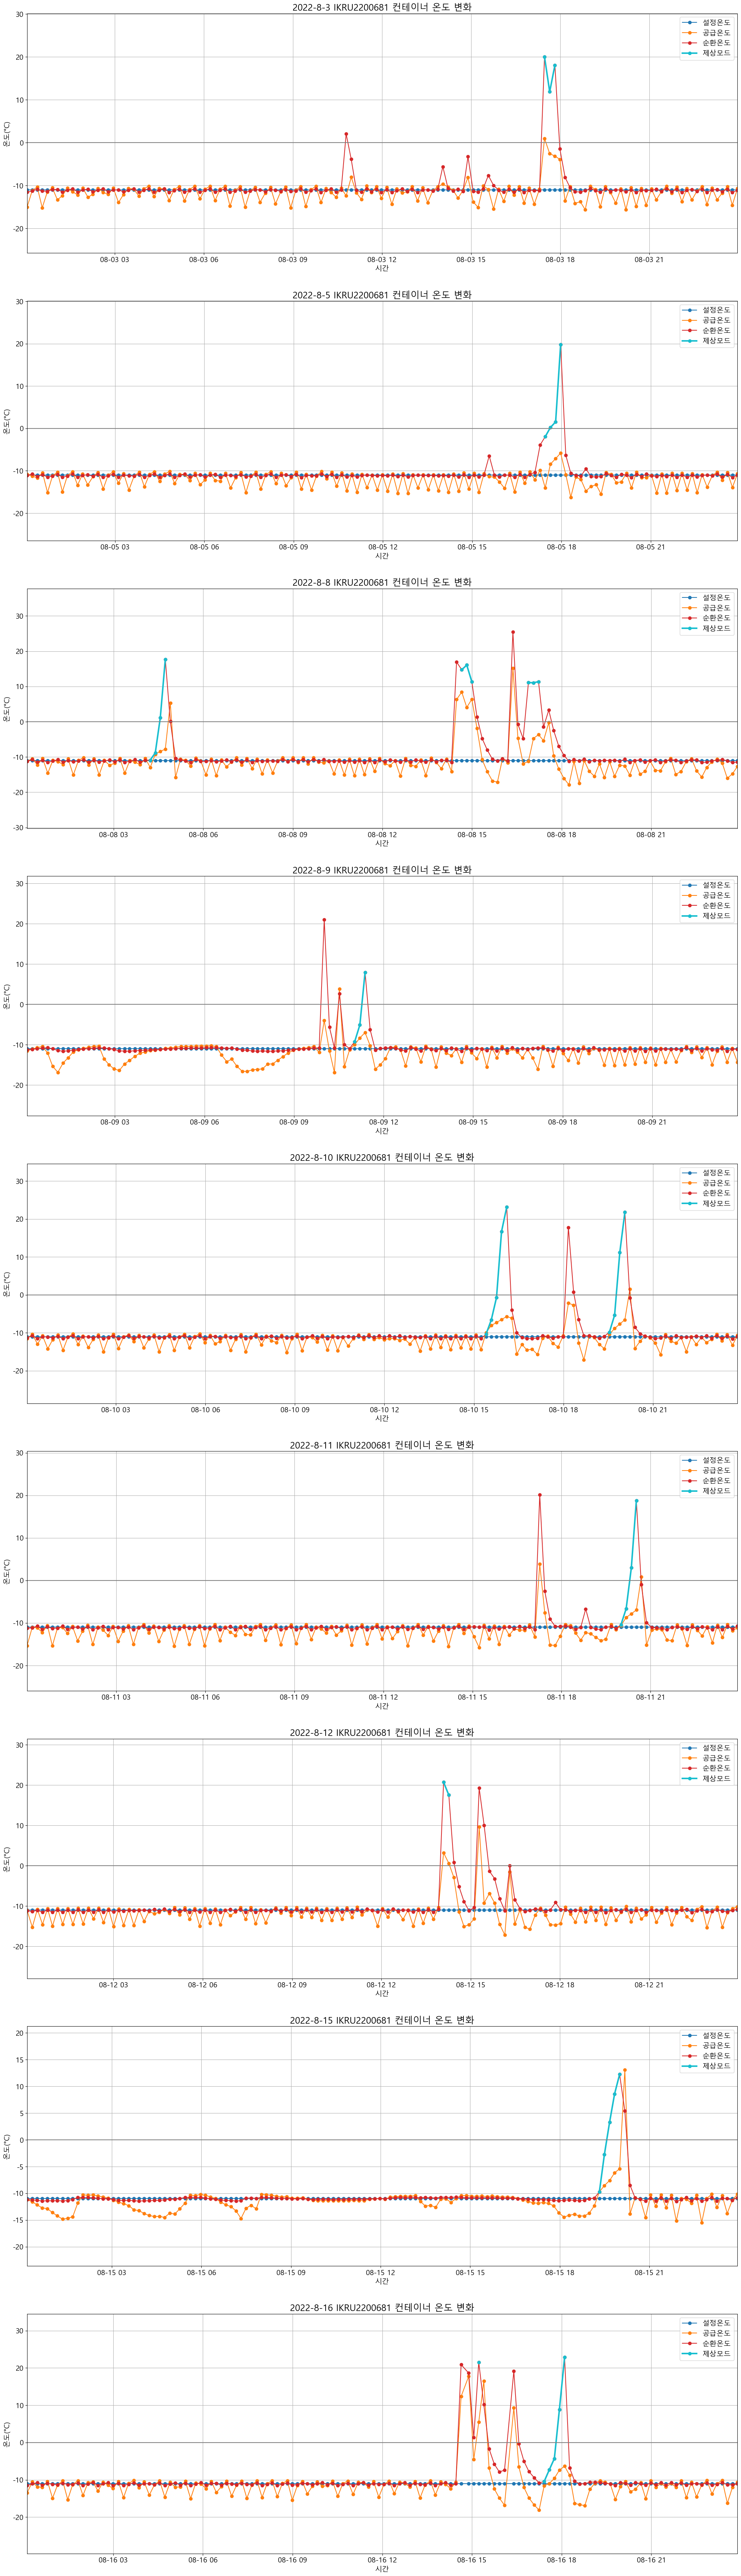

In [27]:
draw_lineplot(df_timestamp_list[:9])

<Figure size 640x480 with 0 Axes>

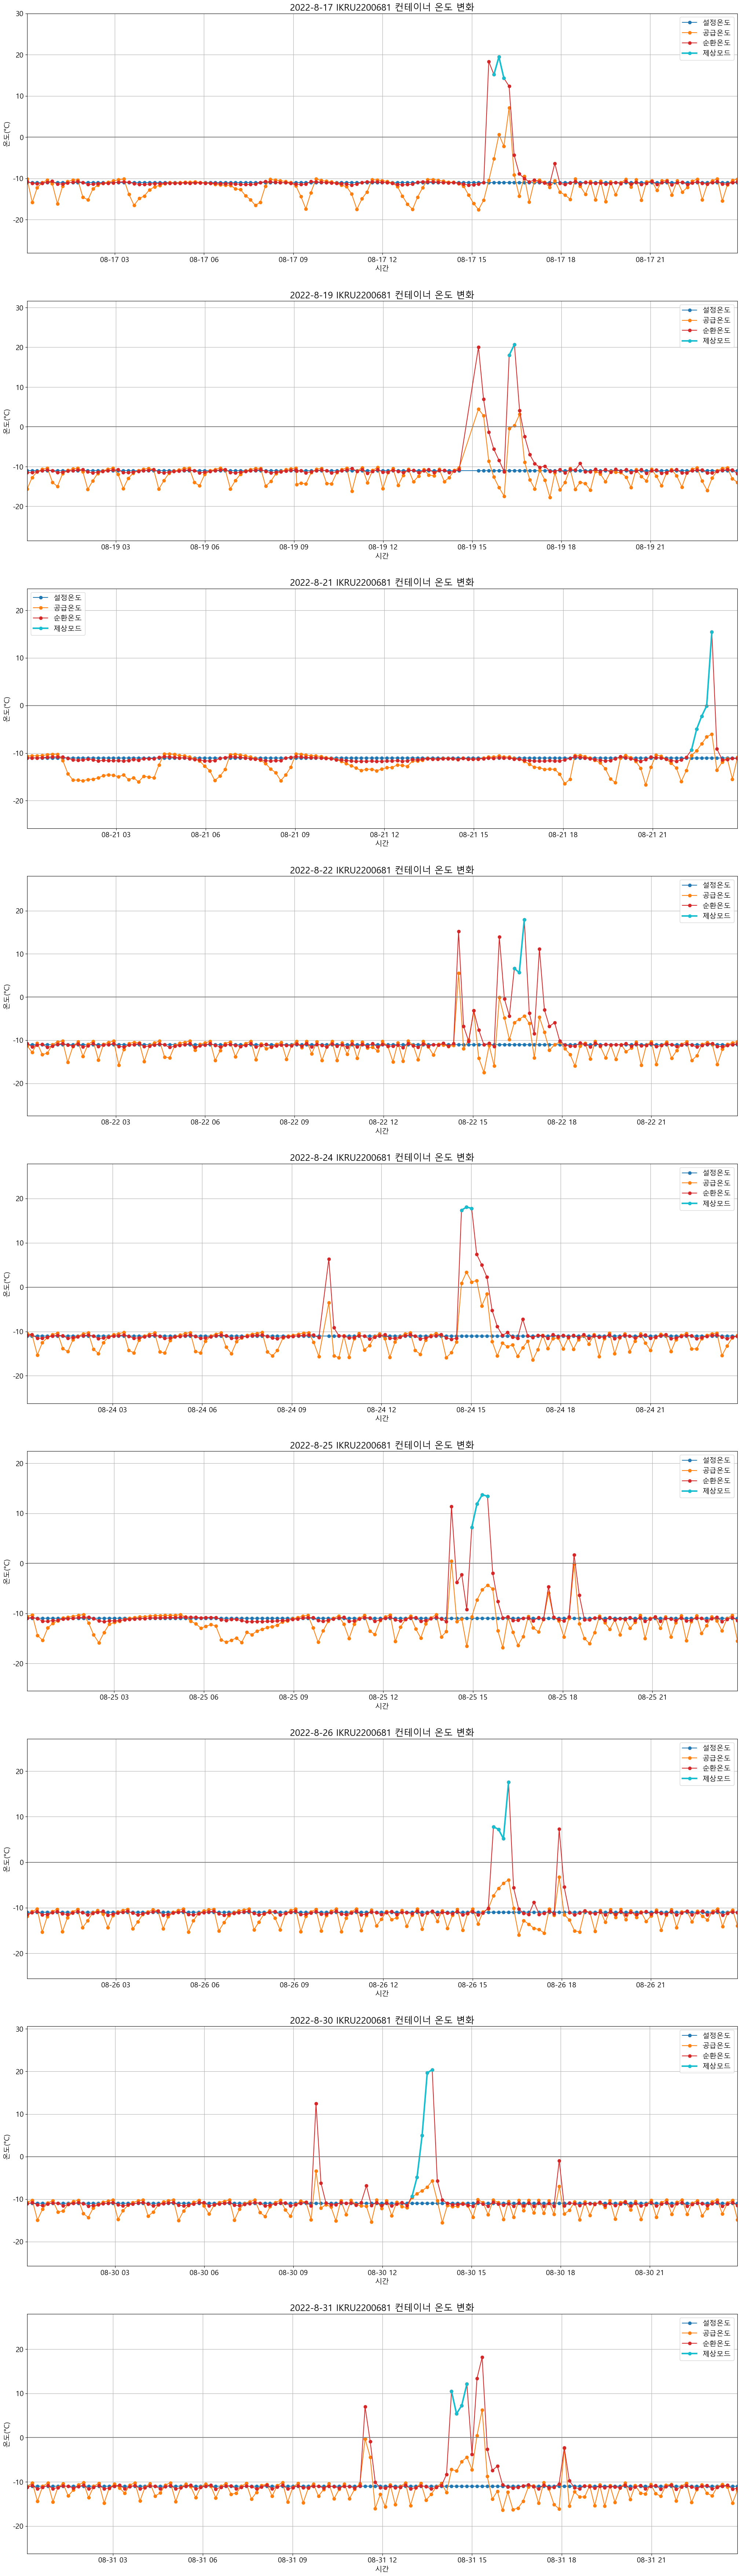

In [28]:
draw_lineplot(df_timestamp_list[9:])

<Figure size 640x480 with 0 Axes>

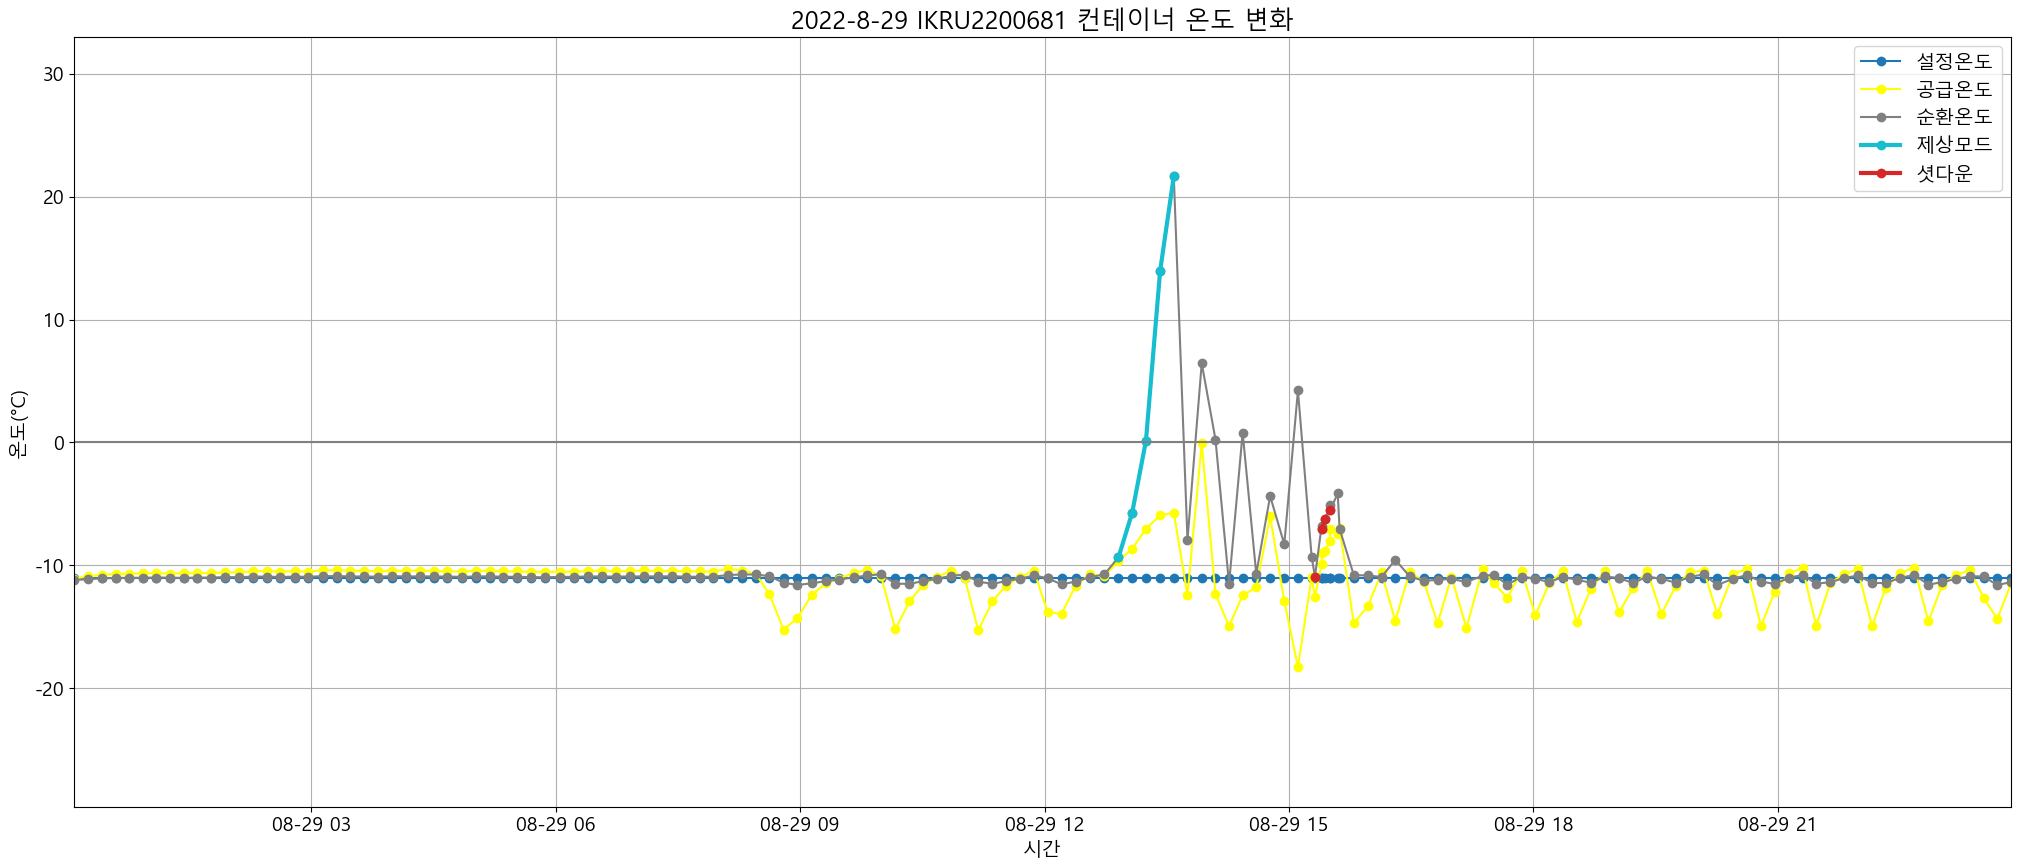

In [29]:
draw_lineplot(df_shutdown_list, "SHUTDOWN")

# 현재까지 봤을 때의 생각
1. 갑자기 온도가 상승하는 횟수를 카운팅해서 정상과 고장의 경우를 비교해보고 싶다. -> 고장인 데이터만 봤을 때는 갑자기 급상승하는 경우가 종종 있었음
2. DEFROST 이후 온도가 내려가는 시간이 늘어날 수록 성능 저하가 됐고 고장이 잘 난다? -> 아직까지는 모르겠음
3. 생각이 정리되면 확인할 예정

### 2-1-3. 설정 온도에 따른 순환온도 확인

설정 온도에 따라 순환 온도가 얼마나 똑같이 가는지 확인

In [30]:
df_carrier['temperature_setpoint'].unique()

array([  9.5, -20. , -11. , -21. ,   5. , -18. , -30. , -19.5, -25. ,
       -19. ,   8. ,   7.5, -12. ,   6.1,   9. , -28. ,   4.5,   4. ,
         1. ,   2. ,  -5. , -27.5,  14. , -29. ,  13.5, -19.8, -20.5,
         4.9,  13. , -15. , -25.1,   3. ,  30. , -18.5, -10. ,  10. ,
         0. , -16.3, -26. ,   0.5, -19.6,  -3. , -15.5,  26. , -16.5,
        12.5,  12. ,  11.5,  11. , -29.5, -13. , -14.5, -14.3,   1.5])

In [67]:
for i in df_carrier['temperature_setpoint'].unique()[-5:-4]:
    print(f"설정온도가 {i}도인 경우의 데이터프레임")
    display(df_carrier.loc[df_carrier['temperature_setpoint'] == i])
    print(df_carrier.loc[df_carrier['temperature_setpoint'] == i, 'reefer_id'].unique())

설정온도가 -29.49999999999997도인 경우의 데이터프레임


,alarm_codes,ambient_temperature,made_cd,operating_mode,operating_mode_str,reefer_id,return_air_temperature,supply_air_temperature,temperature_setpoint,when_created
139069,NaN,21.42,CARRIER,5.0,DEFROST,LXLU5842534,3.53,-19.84,-29.5,2022-08-29 18:12:50
139112,NaN,20.42,CARRIER,5.0,DEFROST,LXLU5842534,2.73,-16.90,-29.5,2022-08-29 18:23:15
139156,NaN,19.60,CARRIER,3.0,COOL,LXLU5842534,-0.55,-13.69,-29.5,2022-08-29 18:33:44
139199,NaN,20.92,CARRIER,3.0,COOL,LXLU5842534,-10.22,-10.53,-29.5,2022-08-29 18:44:02
139242,NaN,21.22,CARRIER,3.0,COOL,LXLU5842534,-13.21,-11.03,-29.5,2022-08-29 18:54:08
...,...,...,...,...,...,...,...,...,...,...
152528,NaN,21.50,CARRIER,3.0,COOL,LXLU5842534,-23.07,-23.61,-29.5,2022-08-31 23:15:09
152575,NaN,21.48,CARRIER,3.0,COOL,LXLU5842534,-23.28,-24.11,-29.5,2022-08-31 23:25:15
152620,NaN,21.49,CARRIER,3.0,COOL,LXLU5842534,-23.58,-24.56,-29.5,2022-08-31 23:35:43
152663,NaN,21.74,CARRIER,3.0,COOL,LXLU5842534,-23.80,-24.88,-29.5,2022-08-31 23:45:46


['LXLU5842534']


In [68]:
aa = df_carrier.loc[df_carrier['reefer_id'] == 'LXLU5842534']

In [69]:
aa['when_created'].dt.day.value_counts()

9     142
1     141
17    141
30    141
28    141
27    141
25    141
21    141
19    141
3     141
18    141
11    141
10    141
8     141
7     141
31    141
14    140
12    140
20    140
22    140
24    140
26    140
29    140
5     136
15    132
16     87
Name: when_created, dtype: int64

In [74]:
aa_08_05 = find_timestamp_dataframe(2022, 8, 5, aa).set_index('when_created')
aa_08_03 = find_timestamp_dataframe(2022, 8, 3, aa).set_index('when_created')
aa_08_01 = find_timestamp_dataframe(2022, 8, 1, aa).set_index('when_created')

In [75]:
aa_list = [aa_08_05, aa_08_03, aa_08_01]

In [76]:
# DEFROST와 SHUTDOWN을 시각화할 수 있도록 데이터 수정
df_shutdown_list = []
del_index_list = []
for i, df in enumerate(aa_list):
    df['IS_DEFROST'] = df.apply(lambda x:is_defrost(x['return_air_temperature'], x['operating_mode_str']), axis=1)
    if "SHUTDOWN" in df['operating_mode_str'].unique():
        df['IS_SHUTDOWN'] = df.apply(lambda x:is_shutdown(x['return_air_temperature'], x['operating_mode_str']), axis=1)
        df_shutdown_list.append(aa_list[i])
        del_index_list.append(i)

<Figure size 640x480 with 0 Axes>

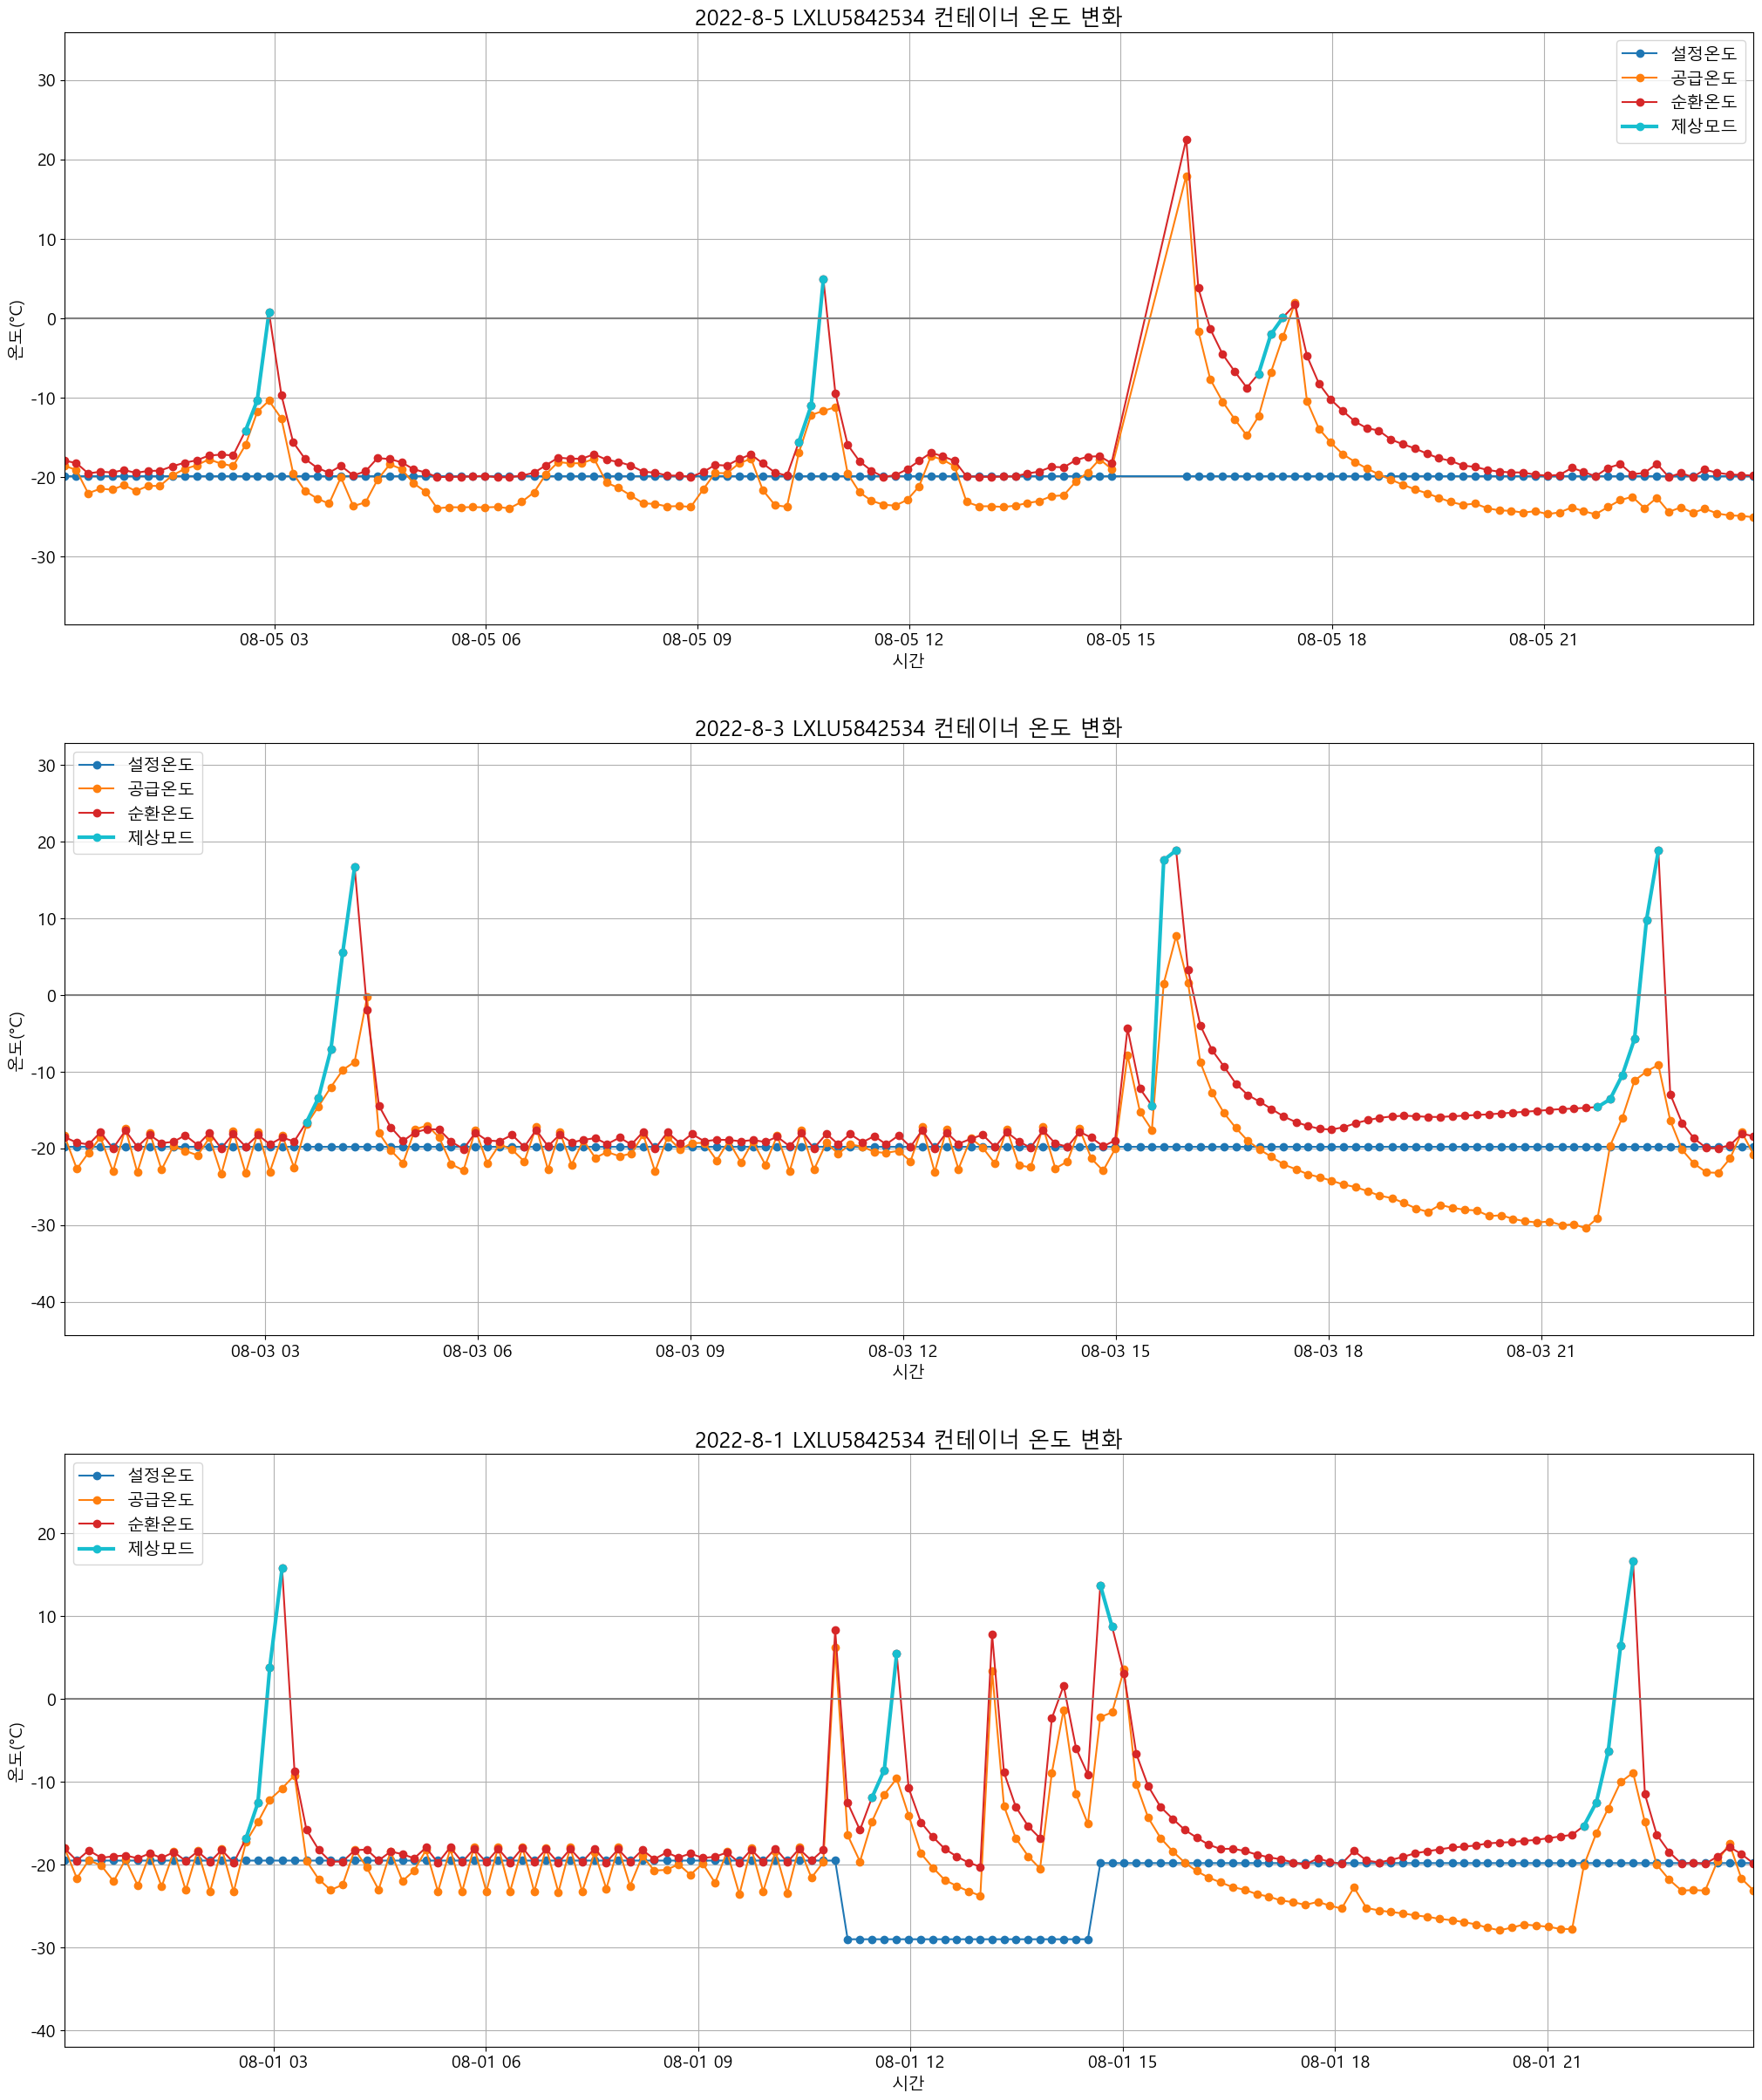

In [77]:
draw_lineplot(aa_list)